In [1]:
# Importing Necessary Libraries
import os
import cv2
import numpy as np
import random
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from tensorflow.keras.applications import VGG16
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Flatten, Dense, Dropout
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint


In [3]:
# Set dataset path
dataset_path = 'C:/Users/omen/Desktop/University Computer Science/Semester 3/Computer Vision/Rice_Image_Dataset'  # Update this path
folders = os.listdir(dataset_path)
print("Folders in dataset:", folders)

Folders in dataset: ['Arborio', 'Basmati', 'Ipsala', 'Jasmine', 'Karacadag']


In [5]:
# Function to load a subset of the dataset
def load_data_subset(img_size=(128, 128), subset_per_class=500):
    images = []
    labels = []
    for idx, folder in enumerate(folders):
        folder_path = os.path.join(dataset_path, folder)
        all_files = os.listdir(folder_path)

        # Randomly select a subset of files
        subset_files = random.sample(all_files, min(subset_per_class, len(all_files)))
        print(f"Using {len(subset_files)} images from class: {folder}")

        for file in subset_files:
            img_path = os.path.join(folder_path, file)
            img = cv2.imread(img_path)
            img = cv2.resize(img, img_size, interpolation=cv2.INTER_AREA)
            img = img / 255.0  # Normalize pixel values
            images.append(img)
            labels.append(idx)
    return np.array(images), np.array(labels)

# Load a subset ( 500 images per class)
images, labels = load_data_subset(subset_per_class=500)
print(f"Subset Loaded: Images shape: {images.shape}, Labels shape: {labels.shape}")

Using 500 images from class: Arborio
Using 500 images from class: Basmati
Using 500 images from class: Ipsala
Using 500 images from class: Jasmine
Using 500 images from class: Karacadag
Subset Loaded: Images shape: (2500, 128, 128, 3), Labels shape: (2500,)


In [7]:
# Split dataset into training and validation sets
X_train, X_val, y_train, y_val = train_test_split(images, labels, test_size=0.2, random_state=42)
print(f"Training data shape: {X_train.shape}, Validation data shape: {X_val.shape}")

Training data shape: (2000, 128, 128, 3), Validation data shape: (500, 128, 128, 3)


In [9]:
# Define data augmentation for training images
datagen = ImageDataGenerator(
    rotation_range=30,
    width_shift_range=0.2,
    height_shift_range=0.2,
    horizontal_flip=True,
    zoom_range=0.2
)

datagen.fit(X_train)


In [11]:
# Load the pre-trained VGG16 model without the top layers
base_model = VGG16(weights='imagenet', include_top=False, input_shape=(128, 128, 3))

# Freeze the base model layers
for layer in base_model.layers:
    layer.trainable = False

# Add custom classification layers on top
x = Flatten()(base_model.output)
x = Dense(128, activation='relu')(x)
x = Dropout(0.5)(x)
output = Dense(len(folders), activation='softmax')(x)

# Define the complete model
model = Model(inputs=base_model.input, outputs=output)

# Compile the model
model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

# Display the model summary
model.summary()


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)             │ (None, 128, 128, 3)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block1_conv1 (Conv2D)                │ (None, 128, 128, 64)        │           1,792 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block1_conv2 (Conv2D)                │ (None, 128, 128, 64)        │          36,928 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block1_pool (MaxPooling2D)           │ (None, 64, 64, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block2_conv1 (Conv2D)                │ (None, 64, 64, 128)         │          73,856 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block2_conv2 (Conv2D)                │ (None, 64, 64, 128)         │         147,584 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block2_pool (MaxPooling2D)           │ (None, 32, 32, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block3_conv1 (Conv2D)                │ (None, 32, 32, 256)         │         295,168 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block3_conv2 (Conv2D)                │ (None, 32, 32, 256)         │         590,080 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block3_conv3 (Conv2D)                │ (None, 32, 32, 256)         │         590,080 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block3_pool (MaxPooling2D)           │ (None, 16, 16, 256)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block4_conv1 (Conv2D)                │ (None, 16, 16, 512)         │       1,180,160 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block4_conv2 (Conv2D)                │ (None, 16, 16, 512)         │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block4_conv3 (Conv2D)                │ (None, 16, 16, 512)         │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block4_pool (MaxPooling2D)           │ (None, 8, 8, 512)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block5_conv1 (Conv2D)                │ (None, 8, 8, 512)           │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block5_conv2 (Conv2D)                │ (None, 8, 8, 512)           │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block5_conv3 (Conv2D)                │ (None, 8, 8, 512)           │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block5_pool (MaxPooling2D)           │ (None, 4, 4, 512)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten (Flatten)                    │ (None, 8192)                │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 128)                 │       1,048,704 │
├──────────────────────────────────────┼─────────────────────────────┼──────────────

 Total params: 15,764,037 (60.14 MB)

 Trainable params: 1,049,349 (4.00 MB)

 Non-trainable params: 14,714,688 (56.13 MB)

In [15]:
# Define callbacks
early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)
checkpoint = ModelCheckpoint('best_model_vgg16.keras', save_best_only=True, monitor='val_loss', mode='min')

# Train the model
history = model.fit(
    datagen.flow(X_train, y_train, batch_size=32),
    validation_data=(X_val, y_val),
    epochs=20,
    callbacks=[early_stopping, checkpoint]
)

print("Model training complete!")


C:\Users\omen\anaconda3\Lib\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/20
63/63 ━━━━━━━━━━━━━━━━━━━━ 95s 1s/step - accuracy: 0.4932 - loss: 1.3455 - val_accuracy: 0.9020 - val_loss: 0.3451
Epoch 2/20
63/63 ━━━━━━━━━━━━━━━━━━━━ 89s 1s/step - accuracy: 0.7638 - loss: 0.5869 - val_accuracy: 0.9280 - val_loss: 0.2538
Epoch 3/20
63/63 ━━━━━━━━━━━━━━━━━━━━ 92s 1s/step - accuracy: 0.8073 - loss: 0.5077 - val_accuracy: 0.9460 - val_loss: 0.2155
Epoch 4/20
63/63 ━━━━━━━━━━━━━━━━━━━━ 89s 1s/step - accuracy: 0.8227 - loss: 0.4554 - val_accuracy: 0.9500 - val_loss: 0.1699
Epoch 5/20
63/63 ━━━━━━━━━━━━━━━━━━━━ 88s 1s/step - accuracy: 0.8318 - loss: 0.4452 - val_accuracy: 0.9540 - val_loss: 0.1302
Epoch 6/20
63/63 ━━━━━━━━━━━━━━━━━━━━ 89s 1s/step - accuracy: 0.8377 - loss: 0.3916 - val_accuracy: 0.9700 - val_loss: 0.1203
Epoch 7/20
63/63 ━━━━━━━━━━━━━━━━━━━━ 89s 1s/step - accuracy: 0.8592 - loss: 0.3565 - val_accuracy: 0.9680 - val_loss: 0.1085
Epoch 8/20
63/63 ━━━━━━━━━━━━━━━━━━━━ 89s 1s/step - accuracy: 0.8707 - loss: 0.3528 - val_accuracy: 0.9540 - val_loss:

16/16 ━━━━━━━━━━━━━━━━━━━━ 14s 884ms/step - accuracy: 0.9618 - loss: 0.0924
Validation Accuracy: 97.20%


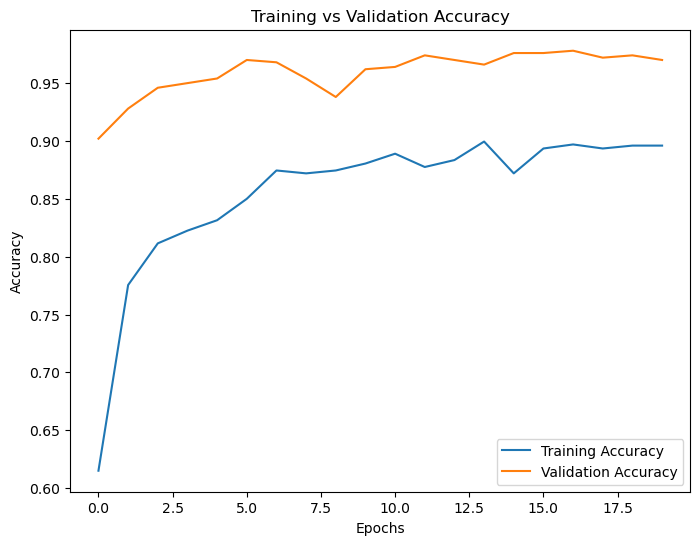

In [18]:
# Evaluate the model on the validation set
val_loss, val_acc = model.evaluate(X_val, y_val)
print(f"Validation Accuracy: {val_acc * 100:.2f}%")

# Plot training vs validation accuracy
plt.figure(figsize=(8, 6))
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('Training vs Validation Accuracy')
plt.legend()
plt.show()


In [20]:
# Path to the test image
test_image_path = 'C:/Users/omen/Downloads/ricee.jpg'  # Updated with test image(arboio)

# Load and preprocess the test image
test_img = cv2.imread(test_image_path)
test_img = cv2.resize(test_img, (128, 128)) / 255.0
test_img = np.expand_dims(test_img, axis=0)

# Predict the class of the test image
prediction = model.predict(test_img)
predicted_class = np.argmax(prediction)
print(f"Predicted Class: {predicted_class}, Rice Variety: {folders[predicted_class]}")


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 374ms/step
Predicted Class: 0, Rice Variety: Arborio
